# **Settings**

In [1]:
# !pip install decord
# !pip install accelerate -U
# !pip install -q pytorchvideo transformers evaluate

# **데이터 불러오기**

In [3]:
# 데이터 목록 확인하기
from glob import glob

dir = glob('unstaffed_stores_data/train/*')
print(dir)

['unstaffed_stores_data/train\\catch', 'unstaffed_stores_data/train\\normal', 'unstaffed_stores_data/train\\put']


In [4]:
dataset_root_path = "unstaffed_stores_data"

In [5]:
import pathlib


dataset_root_path = pathlib.Path(dataset_root_path)
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

[WindowsPath('unstaffed_stores_data/train/catch/catch.mp4'),
 WindowsPath('unstaffed_stores_data/train/catch/catch_0.mp4'),
 WindowsPath('unstaffed_stores_data/train/catch/catch_1.mp4'),
 WindowsPath('unstaffed_stores_data/train/catch/catch_103.mp4'),
 WindowsPath('unstaffed_stores_data/train/catch/catch_104.mp4')]

In [6]:
# 클래스 라벨링하기
class_labels = sorted({str(path).split("\\")[2] for path in all_video_file_paths})       # 폴더명(class명) 가져오기
label2id = {label: i for i, label in enumerate(class_labels)}           # 라벨 : ID
id2label = {i: label for label, i in label2id.items()}                  # ID : 라벨

print(f"Unique classes: {list(label2id.keys())}.")                      # 라벨 출력하기

Unique classes: ['catch', 'normal', 'put'].


In [7]:
print(label2id)
print(id2label)

{'catch': 0, 'normal': 1, 'put': 2}
{0: 'catch', 1: 'normal', 2: 'put'}


# **모델 Settings**

In [8]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


# **Pretrained 모델 불러오기**

In [9]:
from transformers import VivitImageProcessor, VivitForVideoClassification

model_ckpt = "google/vivit-b-16x2-kinetics400"
image_processor = VivitImageProcessor.from_pretrained(model_ckpt)
model = VivitForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of VivitForVideoClassification were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **전처리 설정하기**

In [10]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## **기존 모델의 정보**

In [11]:
image_processor

VivitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "VivitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "offset": true,
  "resample": 2,
  "rescale_factor": 0.00784313725490196,
  "size": {
    "shortest_edge": 224
  }
}

In [12]:
model.config

VivitConfig {
  "_name_or_path": "google/vivit-b-16x2-kinetics400",
  "architectures": [
    "ViViTForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "catch",
    "1": "normal",
    "2": "put"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "catch": 0,
    "normal": 1,
    "put": 2
  },
  "layer_norm_eps": 1e-06,
  "model_type": "vivit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_frames": 32,
  "num_hidden_layers": 12,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.31.0",
  "tubelet_size": [
    2,
    16,
    16
  ],
  "video_size": [
    32,
    224,
    224
  ]
}

In [13]:
# 전처리 설정하기
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)
print(resize_to)

num_frames_to_sample = model.config.num_frames
sample_rate = 44100
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

(224, 224)


# **Data Transform**

In [14]:
import os

train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=224, max_size=224),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

dataset_root_path = "unstaffed_stores_data"
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

In [15]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [16]:
print(train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos)

659 139 145


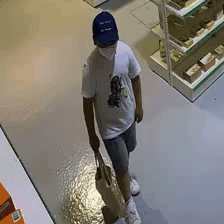

In [18]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [19]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-model"
num_epochs = 6
batch_size = 2

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [20]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [21]:
import torch
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [22]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [23]:
import numpy as np

train_results = trainer.train()

c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: isakin. Use `wandb login --relogin` to force relogin


  0%|          | 0/1974 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
  1%|          | 10/1974 [00:41<45:15,  1.38s/it]  

{'loss': 1.249, 'learning_rate': 2.5252525252525253e-06, 'epoch': 0.01}


  1%|          | 20/1974 [00:50<29:25,  1.11it/s]

{'loss': 1.0776, 'learning_rate': 5.050505050505051e-06, 'epoch': 0.01}


  2%|▏         | 30/1974 [00:59<29:13,  1.11it/s]

{'loss': 1.0726, 'learning_rate': 7.5757575757575764e-06, 'epoch': 0.02}


  2%|▏         | 40/1974 [01:08<28:26,  1.13it/s]

{'loss': 0.7618, 'learning_rate': 1.0101010101010101e-05, 'epoch': 0.02}


  3%|▎         | 50/1974 [01:17<29:04,  1.10it/s]

{'loss': 0.7909, 'learning_rate': 1.2626262626262628e-05, 'epoch': 0.03}


  3%|▎         | 60/1974 [01:27<31:24,  1.02it/s]

{'loss': 0.69, 'learning_rate': 1.5151515151515153e-05, 'epoch': 0.03}


  4%|▎         | 70/1974 [01:37<33:47,  1.06s/it]

{'loss': 0.4597, 'learning_rate': 1.7676767676767676e-05, 'epoch': 0.04}


  4%|▍         | 80/1974 [01:48<34:36,  1.10s/it]

{'loss': 0.421, 'learning_rate': 2.0202020202020203e-05, 'epoch': 0.04}


  5%|▍         | 90/1974 [01:58<28:41,  1.09it/s]

{'loss': 0.3436, 'learning_rate': 2.272727272727273e-05, 'epoch': 0.05}


  5%|▌         | 100/1974 [02:07<28:56,  1.08it/s]

{'loss': 0.4115, 'learning_rate': 2.5252525252525256e-05, 'epoch': 0.05}


  6%|▌         | 110/1974 [02:16<27:47,  1.12it/s]

{'loss': 0.2962, 'learning_rate': 2.777777777777778e-05, 'epoch': 0.06}


  6%|▌         | 120/1974 [02:25<27:32,  1.12it/s]

{'loss': 0.4073, 'learning_rate': 3.0303030303030306e-05, 'epoch': 0.06}


  7%|▋         | 130/1974 [02:34<25:56,  1.18it/s]

{'loss': 0.2411, 'learning_rate': 3.282828282828283e-05, 'epoch': 0.07}


  7%|▋         | 140/1974 [02:43<27:15,  1.12it/s]

{'loss': 0.288, 'learning_rate': 3.535353535353535e-05, 'epoch': 0.07}


  8%|▊         | 150/1974 [02:51<27:45,  1.09it/s]

{'loss': 0.3856, 'learning_rate': 3.787878787878788e-05, 'epoch': 0.08}


  8%|▊         | 160/1974 [02:59<19:40,  1.54it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.1969, 'learning_rate': 4.0404040404040405e-05, 'epoch': 0.08}


  8%|▊         | 160/1974 [03:15<19:40,  1.54it/s]

{'eval_loss': 0.19929499924182892, 'eval_accuracy': 0.9264705882352942, 'eval_runtime': 15.9605, 'eval_samples_per_second': 8.521, 'eval_steps_per_second': 2.13, 'epoch': 0.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
  9%|▊         | 170/1974 [03:25<33:08,  1.10s/it]  

{'loss': 0.1543, 'learning_rate': 4.292929292929293e-05, 'epoch': 1.01}


  9%|▉         | 180/1974 [03:34<26:01,  1.15it/s]

{'loss': 0.1288, 'learning_rate': 4.545454545454546e-05, 'epoch': 1.01}


 10%|▉         | 190/1974 [03:43<24:57,  1.19it/s]

{'loss': 0.1105, 'learning_rate': 4.797979797979798e-05, 'epoch': 1.02}


 10%|█         | 200/1974 [03:51<24:00,  1.23it/s]

{'loss': 0.1383, 'learning_rate': 4.9943693693693694e-05, 'epoch': 1.02}


 11%|█         | 210/1974 [03:59<24:07,  1.22it/s]

{'loss': 0.1138, 'learning_rate': 4.9662162162162164e-05, 'epoch': 1.03}


 11%|█         | 220/1974 [04:07<23:57,  1.22it/s]

{'loss': 0.1463, 'learning_rate': 4.9380630630630634e-05, 'epoch': 1.03}


 12%|█▏        | 230/1974 [04:17<29:26,  1.01s/it]

{'loss': 0.0375, 'learning_rate': 4.90990990990991e-05, 'epoch': 1.04}


 12%|█▏        | 240/1974 [04:27<29:25,  1.02s/it]

{'loss': 0.1848, 'learning_rate': 4.881756756756757e-05, 'epoch': 1.04}


 13%|█▎        | 250/1974 [04:36<24:11,  1.19it/s]

{'loss': 0.013, 'learning_rate': 4.853603603603604e-05, 'epoch': 1.05}


 13%|█▎        | 260/1974 [04:45<25:33,  1.12it/s]

{'loss': 0.144, 'learning_rate': 4.825450450450451e-05, 'epoch': 1.05}


 14%|█▎        | 270/1974 [04:53<24:10,  1.18it/s]

{'loss': 0.1912, 'learning_rate': 4.797297297297298e-05, 'epoch': 1.06}


 14%|█▍        | 280/1974 [05:02<24:09,  1.17it/s]

{'loss': 0.3453, 'learning_rate': 4.769144144144144e-05, 'epoch': 1.06}


 15%|█▍        | 290/1974 [05:11<24:42,  1.14it/s]

{'loss': 0.2382, 'learning_rate': 4.740990990990991e-05, 'epoch': 1.07}


 15%|█▌        | 300/1974 [05:19<24:03,  1.16it/s]

{'loss': 0.1335, 'learning_rate': 4.712837837837838e-05, 'epoch': 1.07}


 16%|█▌        | 310/1974 [05:28<23:36,  1.17it/s]

{'loss': 0.0232, 'learning_rate': 4.684684684684685e-05, 'epoch': 1.08}


 16%|█▌        | 320/1974 [05:36<17:34,  1.57it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.0825, 'learning_rate': 4.656531531531531e-05, 'epoch': 1.08}


 16%|█▌        | 320/1974 [05:51<17:34,  1.57it/s]

{'eval_loss': 0.07825759053230286, 'eval_accuracy': 0.9705882352941176, 'eval_runtime': 15.5042, 'eval_samples_per_second': 8.772, 'eval_steps_per_second': 2.193, 'epoch': 1.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 17%|█▋        | 330/1974 [06:01<29:54,  1.09s/it]  

{'loss': 0.0116, 'learning_rate': 4.628378378378378e-05, 'epoch': 2.01}


 17%|█▋        | 340/1974 [06:10<24:37,  1.11it/s]

{'loss': 0.0036, 'learning_rate': 4.600225225225225e-05, 'epoch': 2.01}


 18%|█▊        | 350/1974 [06:19<23:57,  1.13it/s]

{'loss': 0.0141, 'learning_rate': 4.572072072072072e-05, 'epoch': 2.02}


 18%|█▊        | 360/1974 [06:28<22:17,  1.21it/s]

{'loss': 0.0054, 'learning_rate': 4.543918918918919e-05, 'epoch': 2.02}


 19%|█▊        | 370/1974 [06:36<21:53,  1.22it/s]

{'loss': 0.0055, 'learning_rate': 4.5157657657657656e-05, 'epoch': 2.03}


 19%|█▉        | 380/1974 [06:44<22:48,  1.16it/s]

{'loss': 0.0028, 'learning_rate': 4.4876126126126126e-05, 'epoch': 2.03}


 20%|█▉        | 390/1974 [06:53<22:13,  1.19it/s]

{'loss': 0.0083, 'learning_rate': 4.4594594594594596e-05, 'epoch': 2.04}


 20%|██        | 400/1974 [07:01<21:55,  1.20it/s]

{'loss': 0.0011, 'learning_rate': 4.4313063063063066e-05, 'epoch': 2.04}


 21%|██        | 410/1974 [07:09<21:55,  1.19it/s]

{'loss': 0.2408, 'learning_rate': 4.4031531531531536e-05, 'epoch': 2.05}


 21%|██▏       | 420/1974 [07:18<22:39,  1.14it/s]

{'loss': 0.0039, 'learning_rate': 4.375e-05, 'epoch': 2.05}


 22%|██▏       | 430/1974 [07:27<22:15,  1.16it/s]

{'loss': 0.001, 'learning_rate': 4.346846846846847e-05, 'epoch': 2.06}


 22%|██▏       | 440/1974 [07:35<21:10,  1.21it/s]

{'loss': 0.0006, 'learning_rate': 4.318693693693694e-05, 'epoch': 2.06}


 23%|██▎       | 450/1974 [07:43<21:21,  1.19it/s]

{'loss': 0.0005, 'learning_rate': 4.290540540540541e-05, 'epoch': 2.07}


 23%|██▎       | 460/1974 [07:52<21:39,  1.16it/s]

{'loss': 0.0004, 'learning_rate': 4.262387387387388e-05, 'epoch': 2.07}


 24%|██▍       | 470/1974 [08:01<22:13,  1.13it/s]

{'loss': 0.0004, 'learning_rate': 4.234234234234234e-05, 'epoch': 2.08}


 24%|██▍       | 480/1974 [08:08<15:40,  1.59it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.0004, 'learning_rate': 4.206081081081081e-05, 'epoch': 2.08}


 24%|██▍       | 480/1974 [08:24<15:40,  1.59it/s]

{'eval_loss': 0.04701579362154007, 'eval_accuracy': 0.9926470588235294, 'eval_runtime': 15.9134, 'eval_samples_per_second': 8.546, 'eval_steps_per_second': 2.137, 'epoch': 2.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 25%|██▍       | 490/1974 [08:34<26:02,  1.05s/it]  

{'loss': 0.0003, 'learning_rate': 4.177927927927928e-05, 'epoch': 3.01}


 25%|██▌       | 500/1974 [08:42<21:00,  1.17it/s]

{'loss': 0.0005, 'learning_rate': 4.149774774774775e-05, 'epoch': 3.01}


 26%|██▌       | 510/1974 [08:51<21:36,  1.13it/s]

{'loss': 0.0015, 'learning_rate': 4.1216216216216216e-05, 'epoch': 3.02}


 26%|██▋       | 520/1974 [09:00<20:59,  1.15it/s]

{'loss': 0.0756, 'learning_rate': 4.0934684684684686e-05, 'epoch': 3.02}


 27%|██▋       | 530/1974 [09:08<20:26,  1.18it/s]

{'loss': 0.0003, 'learning_rate': 4.0653153153153156e-05, 'epoch': 3.03}


 27%|██▋       | 540/1974 [09:17<20:21,  1.17it/s]

{'loss': 0.0028, 'learning_rate': 4.0371621621621626e-05, 'epoch': 3.03}


 28%|██▊       | 550/1974 [09:25<20:07,  1.18it/s]

{'loss': 0.0019, 'learning_rate': 4.0090090090090096e-05, 'epoch': 3.04}


 28%|██▊       | 560/1974 [09:34<20:12,  1.17it/s]

{'loss': 0.0003, 'learning_rate': 3.980855855855856e-05, 'epoch': 3.04}


 29%|██▉       | 570/1974 [09:42<19:47,  1.18it/s]

{'loss': 0.0003, 'learning_rate': 3.952702702702703e-05, 'epoch': 3.05}


 29%|██▉       | 580/1974 [09:51<19:38,  1.18it/s]

{'loss': 0.001, 'learning_rate': 3.92454954954955e-05, 'epoch': 3.05}


 30%|██▉       | 590/1974 [10:00<20:18,  1.14it/s]

{'loss': 0.0005, 'learning_rate': 3.896396396396397e-05, 'epoch': 3.06}


 30%|███       | 600/1974 [10:08<19:57,  1.15it/s]

{'loss': 0.0004, 'learning_rate': 3.868243243243244e-05, 'epoch': 3.06}


 31%|███       | 610/1974 [10:17<19:46,  1.15it/s]

{'loss': 0.0001, 'learning_rate': 3.84009009009009e-05, 'epoch': 3.07}


 31%|███▏      | 620/1974 [10:26<19:22,  1.17it/s]

{'loss': 0.0002, 'learning_rate': 3.811936936936937e-05, 'epoch': 3.07}


 32%|███▏      | 630/1974 [10:34<18:52,  1.19it/s]

{'loss': 0.1352, 'learning_rate': 3.783783783783784e-05, 'epoch': 3.08}


 32%|███▏      | 640/1974 [10:42<14:08,  1.57it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.0003, 'learning_rate': 3.755630630630631e-05, 'epoch': 3.08}


 32%|███▏      | 640/1974 [10:57<14:08,  1.57it/s]

{'eval_loss': 0.23589293658733368, 'eval_accuracy': 0.9338235294117647, 'eval_runtime': 15.2919, 'eval_samples_per_second': 8.894, 'eval_steps_per_second': 2.223, 'epoch': 3.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 33%|███▎      | 650/1974 [11:07<23:28,  1.06s/it]  

{'loss': 0.0038, 'learning_rate': 3.727477477477478e-05, 'epoch': 4.01}


 33%|███▎      | 660/1974 [11:16<18:26,  1.19it/s]

{'loss': 0.0002, 'learning_rate': 3.6993243243243245e-05, 'epoch': 4.01}


 34%|███▍      | 670/1974 [11:24<18:54,  1.15it/s]

{'loss': 0.0005, 'learning_rate': 3.6711711711711715e-05, 'epoch': 4.02}


 34%|███▍      | 680/1974 [11:33<18:23,  1.17it/s]

{'loss': 0.0002, 'learning_rate': 3.6430180180180185e-05, 'epoch': 4.02}


 35%|███▍      | 690/1974 [11:41<17:48,  1.20it/s]

{'loss': 0.155, 'learning_rate': 3.6148648648648655e-05, 'epoch': 4.03}


 35%|███▌      | 700/1974 [11:50<17:37,  1.20it/s]

{'loss': 0.0003, 'learning_rate': 3.586711711711712e-05, 'epoch': 4.03}


 36%|███▌      | 710/1974 [11:58<18:22,  1.15it/s]

{'loss': 0.0005, 'learning_rate': 3.558558558558558e-05, 'epoch': 4.04}


 36%|███▋      | 720/1974 [12:07<17:44,  1.18it/s]

{'loss': 0.0003, 'learning_rate': 3.530405405405405e-05, 'epoch': 4.04}


 37%|███▋      | 730/1974 [12:15<17:34,  1.18it/s]

{'loss': 0.0002, 'learning_rate': 3.502252252252252e-05, 'epoch': 4.05}


 37%|███▋      | 740/1974 [12:24<17:18,  1.19it/s]

{'loss': 0.0002, 'learning_rate': 3.474099099099099e-05, 'epoch': 4.05}


 38%|███▊      | 750/1974 [12:32<17:13,  1.18it/s]

{'loss': 0.0003, 'learning_rate': 3.445945945945946e-05, 'epoch': 4.06}


 39%|███▊      | 760/1974 [12:41<16:46,  1.21it/s]

{'loss': 0.0002, 'learning_rate': 3.4177927927927925e-05, 'epoch': 4.06}


 39%|███▉      | 770/1974 [12:49<17:29,  1.15it/s]

{'loss': 0.0002, 'learning_rate': 3.3896396396396395e-05, 'epoch': 4.07}


 40%|███▉      | 780/1974 [12:58<17:01,  1.17it/s]

{'loss': 0.0002, 'learning_rate': 3.3614864864864865e-05, 'epoch': 4.07}


 40%|████      | 790/1974 [13:06<16:50,  1.17it/s]

{'loss': 0.0002, 'learning_rate': 3.3333333333333335e-05, 'epoch': 4.08}


 41%|████      | 800/1974 [13:14<12:04,  1.62it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.0001, 'learning_rate': 3.3051801801801805e-05, 'epoch': 4.08}


 41%|████      | 800/1974 [13:30<12:04,  1.62it/s]

{'eval_loss': 0.04790845513343811, 'eval_accuracy': 0.9926470588235294, 'eval_runtime': 16.1293, 'eval_samples_per_second': 8.432, 'eval_steps_per_second': 2.108, 'epoch': 4.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 41%|████      | 810/1974 [13:40<20:57,  1.08s/it]  

{'loss': 0.0001, 'learning_rate': 3.277027027027027e-05, 'epoch': 5.01}


 42%|████▏     | 820/1974 [13:49<17:05,  1.13it/s]

{'loss': 0.0001, 'learning_rate': 3.248873873873874e-05, 'epoch': 5.01}


 42%|████▏     | 830/1974 [13:58<16:50,  1.13it/s]

{'loss': 0.0001, 'learning_rate': 3.220720720720721e-05, 'epoch': 5.02}


 43%|████▎     | 840/1974 [14:06<15:52,  1.19it/s]

{'loss': 0.0001, 'learning_rate': 3.192567567567568e-05, 'epoch': 5.02}


 43%|████▎     | 850/1974 [14:15<16:13,  1.15it/s]

{'loss': 0.0001, 'learning_rate': 3.164414414414414e-05, 'epoch': 5.03}


 44%|████▎     | 860/1974 [14:23<15:43,  1.18it/s]

{'loss': 0.0001, 'learning_rate': 3.136261261261261e-05, 'epoch': 5.03}


 44%|████▍     | 870/1974 [14:32<15:19,  1.20it/s]

{'loss': 0.0001, 'learning_rate': 3.108108108108108e-05, 'epoch': 5.04}


 45%|████▍     | 880/1974 [14:40<15:21,  1.19it/s]

{'loss': 0.0002, 'learning_rate': 3.079954954954955e-05, 'epoch': 5.04}


 45%|████▌     | 890/1974 [14:49<15:21,  1.18it/s]

{'loss': 0.0001, 'learning_rate': 3.051801801801802e-05, 'epoch': 5.05}


 46%|████▌     | 900/1974 [14:57<14:47,  1.21it/s]

{'loss': 0.0001, 'learning_rate': 3.0236486486486488e-05, 'epoch': 5.05}


 46%|████▌     | 910/1974 [15:05<13:20,  1.33it/s]

{'loss': 0.0001, 'learning_rate': 2.9954954954954954e-05, 'epoch': 5.06}


 47%|████▋     | 920/1974 [15:12<12:46,  1.37it/s]

{'loss': 0.0001, 'learning_rate': 2.9673423423423424e-05, 'epoch': 5.06}


 47%|████▋     | 930/1974 [15:19<12:31,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 2.9391891891891894e-05, 'epoch': 5.07}


 48%|████▊     | 940/1974 [15:26<12:43,  1.35it/s]

{'loss': 0.0001, 'learning_rate': 2.911036036036036e-05, 'epoch': 5.07}


 48%|████▊     | 950/1974 [15:34<12:38,  1.35it/s]

{'loss': 0.0001, 'learning_rate': 2.882882882882883e-05, 'epoch': 5.08}


 49%|████▊     | 960/1974 [15:40<09:18,  1.81it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.0001, 'learning_rate': 2.8547297297297298e-05, 'epoch': 5.08}


 49%|████▊     | 960/1974 [15:54<09:18,  1.81it/s]

{'eval_loss': 0.04847909137606621, 'eval_accuracy': 0.9926470588235294, 'eval_runtime': 13.5377, 'eval_samples_per_second': 10.046, 'eval_steps_per_second': 2.511, 'epoch': 5.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 49%|████▉     | 970/1974 [16:03<15:30,  1.08it/s]  

{'loss': 0.0001, 'learning_rate': 2.8265765765765768e-05, 'epoch': 6.01}


 50%|████▉     | 980/1974 [16:10<12:11,  1.36it/s]

{'loss': 0.0001, 'learning_rate': 2.7984234234234234e-05, 'epoch': 6.01}


 50%|█████     | 990/1974 [16:18<12:04,  1.36it/s]

{'loss': 0.0001, 'learning_rate': 2.7702702702702704e-05, 'epoch': 6.02}


 51%|█████     | 1000/1974 [16:25<11:55,  1.36it/s]

{'loss': 0.0001, 'learning_rate': 2.7421171171171174e-05, 'epoch': 6.02}


 51%|█████     | 1010/1974 [16:32<11:34,  1.39it/s]

{'loss': 0.0001, 'learning_rate': 2.713963963963964e-05, 'epoch': 6.03}


 52%|█████▏    | 1020/1974 [16:40<11:23,  1.40it/s]

{'loss': 0.0001, 'learning_rate': 2.685810810810811e-05, 'epoch': 6.03}


 52%|█████▏    | 1030/1974 [16:47<11:37,  1.35it/s]

{'loss': 0.0001, 'learning_rate': 2.6576576576576577e-05, 'epoch': 6.04}


 53%|█████▎    | 1040/1974 [16:54<11:08,  1.40it/s]

{'loss': 0.0001, 'learning_rate': 2.6295045045045047e-05, 'epoch': 6.04}


 53%|█████▎    | 1050/1974 [17:01<11:15,  1.37it/s]

{'loss': 0.0001, 'learning_rate': 2.6013513513513514e-05, 'epoch': 6.05}


 54%|█████▎    | 1060/1974 [17:09<11:06,  1.37it/s]

{'loss': 0.0001, 'learning_rate': 2.5731981981981984e-05, 'epoch': 6.05}


 54%|█████▍    | 1070/1974 [17:16<11:02,  1.36it/s]

{'loss': 0.0001, 'learning_rate': 2.5450450450450454e-05, 'epoch': 6.06}


 55%|█████▍    | 1080/1974 [17:23<10:46,  1.38it/s]

{'loss': 0.0001, 'learning_rate': 2.516891891891892e-05, 'epoch': 6.06}


 55%|█████▌    | 1090/1974 [17:31<11:00,  1.34it/s]

{'loss': 0.0001, 'learning_rate': 2.488738738738739e-05, 'epoch': 6.07}


 56%|█████▌    | 1100/1974 [17:38<10:39,  1.37it/s]

{'loss': 0.0001, 'learning_rate': 2.4605855855855857e-05, 'epoch': 6.07}


 56%|█████▌    | 1110/1974 [17:45<10:31,  1.37it/s]

{'loss': 0.0001, 'learning_rate': 2.4324324324324327e-05, 'epoch': 6.08}


 57%|█████▋    | 1120/1974 [17:53<09:09,  1.56it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.0001, 'learning_rate': 2.4042792792792794e-05, 'epoch': 6.08}


 57%|█████▋    | 1120/1974 [18:08<09:09,  1.56it/s]

{'eval_loss': 0.047358181327581406, 'eval_accuracy': 0.9926470588235294, 'eval_runtime': 15.3935, 'eval_samples_per_second': 8.835, 'eval_steps_per_second': 2.209, 'epoch': 6.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 57%|█████▋    | 1130/1974 [18:18<15:06,  1.07s/it]  

{'loss': 0.0001, 'learning_rate': 2.376126126126126e-05, 'epoch': 7.01}


 58%|█████▊    | 1140/1974 [18:27<12:42,  1.09it/s]

{'loss': 0.0001, 'learning_rate': 2.347972972972973e-05, 'epoch': 7.01}


 58%|█████▊    | 1150/1974 [18:36<12:46,  1.07it/s]

{'loss': 0.0001, 'learning_rate': 2.3198198198198197e-05, 'epoch': 7.02}


 59%|█████▉    | 1160/1974 [18:45<11:41,  1.16it/s]

{'loss': 0.0001, 'learning_rate': 2.2916666666666667e-05, 'epoch': 7.02}


 59%|█████▉    | 1170/1974 [18:53<11:35,  1.16it/s]

{'loss': 0.0001, 'learning_rate': 2.2635135135135137e-05, 'epoch': 7.03}


 60%|█████▉    | 1180/1974 [19:02<11:32,  1.15it/s]

{'loss': 0.0001, 'learning_rate': 2.2353603603603604e-05, 'epoch': 7.03}


 60%|██████    | 1190/1974 [19:11<11:44,  1.11it/s]

{'loss': 0.0001, 'learning_rate': 2.2072072072072073e-05, 'epoch': 7.04}


 61%|██████    | 1200/1974 [19:19<11:14,  1.15it/s]

{'loss': 0.0001, 'learning_rate': 2.179054054054054e-05, 'epoch': 7.04}


 61%|██████▏   | 1210/1974 [19:28<10:44,  1.19it/s]

{'loss': 0.0001, 'learning_rate': 2.150900900900901e-05, 'epoch': 7.05}


 62%|██████▏   | 1220/1974 [19:36<10:46,  1.17it/s]

{'loss': 0.0001, 'learning_rate': 2.1227477477477477e-05, 'epoch': 7.05}


 62%|██████▏   | 1230/1974 [19:45<10:39,  1.16it/s]

{'loss': 0.0001, 'learning_rate': 2.0945945945945947e-05, 'epoch': 7.06}


 63%|██████▎   | 1240/1974 [19:54<10:25,  1.17it/s]

{'loss': 0.0001, 'learning_rate': 2.0664414414414417e-05, 'epoch': 7.06}


 63%|██████▎   | 1250/1974 [20:02<10:23,  1.16it/s]

{'loss': 0.0001, 'learning_rate': 2.0382882882882883e-05, 'epoch': 7.07}


 64%|██████▍   | 1260/1974 [20:11<10:05,  1.18it/s]

{'loss': 0.0001, 'learning_rate': 2.0101351351351353e-05, 'epoch': 7.07}


 64%|██████▍   | 1270/1974 [20:19<10:01,  1.17it/s]

{'loss': 0.0001, 'learning_rate': 1.981981981981982e-05, 'epoch': 7.08}


 65%|██████▍   | 1280/1974 [20:27<07:20,  1.58it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.0001, 'learning_rate': 1.953828828828829e-05, 'epoch': 7.08}


 65%|██████▍   | 1280/1974 [20:43<07:20,  1.58it/s]

{'eval_loss': 0.049715012311935425, 'eval_accuracy': 0.9926470588235294, 'eval_runtime': 15.1279, 'eval_samples_per_second': 8.99, 'eval_steps_per_second': 2.247, 'epoch': 7.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 65%|██████▌   | 1290/1974 [20:52<11:58,  1.05s/it]  

{'loss': 0.0001, 'learning_rate': 1.9256756756756756e-05, 'epoch': 8.01}


 66%|██████▌   | 1300/1974 [21:01<09:46,  1.15it/s]

{'loss': 0.0001, 'learning_rate': 1.8975225225225226e-05, 'epoch': 8.01}


 66%|██████▋   | 1310/1974 [21:10<09:29,  1.17it/s]

{'loss': 0.0001, 'learning_rate': 1.8693693693693696e-05, 'epoch': 8.02}


 67%|██████▋   | 1320/1974 [21:18<09:21,  1.16it/s]

{'loss': 0.0001, 'learning_rate': 1.8412162162162163e-05, 'epoch': 8.02}


 67%|██████▋   | 1330/1974 [21:27<09:22,  1.15it/s]

{'loss': 0.0001, 'learning_rate': 1.8130630630630633e-05, 'epoch': 8.03}


 68%|██████▊   | 1340/1974 [21:35<08:51,  1.19it/s]

{'loss': 0.0001, 'learning_rate': 1.78490990990991e-05, 'epoch': 8.03}


 68%|██████▊   | 1350/1974 [21:44<08:59,  1.16it/s]

{'loss': 0.0001, 'learning_rate': 1.756756756756757e-05, 'epoch': 8.04}


 69%|██████▉   | 1360/1974 [21:53<08:42,  1.17it/s]

{'loss': 0.0001, 'learning_rate': 1.728603603603604e-05, 'epoch': 8.04}


 69%|██████▉   | 1370/1974 [22:01<09:06,  1.10it/s]

{'loss': 0.0001, 'learning_rate': 1.7004504504504506e-05, 'epoch': 8.05}


 70%|██████▉   | 1380/1974 [22:10<08:34,  1.15it/s]

{'loss': 0.0001, 'learning_rate': 1.6722972972972976e-05, 'epoch': 8.05}


 70%|███████   | 1390/1974 [22:19<08:20,  1.17it/s]

{'loss': 0.0, 'learning_rate': 1.6441441441441443e-05, 'epoch': 8.06}


 71%|███████   | 1400/1974 [22:27<08:11,  1.17it/s]

{'loss': 0.0, 'learning_rate': 1.615990990990991e-05, 'epoch': 8.06}


 71%|███████▏  | 1410/1974 [22:36<08:04,  1.16it/s]

{'loss': 0.0001, 'learning_rate': 1.587837837837838e-05, 'epoch': 8.07}


 72%|███████▏  | 1420/1974 [22:44<07:46,  1.19it/s]

{'loss': 0.0001, 'learning_rate': 1.5596846846846846e-05, 'epoch': 8.07}


 72%|███████▏  | 1430/1974 [22:53<07:47,  1.16it/s]

{'loss': 0.0001, 'learning_rate': 1.5315315315315316e-05, 'epoch': 8.08}


 73%|███████▎  | 1440/1974 [23:01<05:39,  1.57it/s]

{'loss': 0.0, 'learning_rate': 1.5033783783783784e-05, 'epoch': 8.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 73%|███████▎  | 1440/1974 [23:16<05:39,  1.57it/s]

{'eval_loss': 0.05087098851799965, 'eval_accuracy': 0.9926470588235294, 'eval_runtime': 15.2854, 'eval_samples_per_second': 8.897, 'eval_steps_per_second': 2.224, 'epoch': 8.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 73%|███████▎  | 1450/1974 [23:26<09:44,  1.12s/it]

{'loss': 0.0001, 'learning_rate': 1.4752252252252253e-05, 'epoch': 9.01}


 74%|███████▍  | 1460/1974 [23:35<07:21,  1.16it/s]

{'loss': 0.0001, 'learning_rate': 1.447072072072072e-05, 'epoch': 9.01}


 74%|███████▍  | 1470/1974 [23:44<07:32,  1.11it/s]

{'loss': 0.0, 'learning_rate': 1.4189189189189189e-05, 'epoch': 9.02}


 75%|███████▍  | 1480/1974 [23:52<07:07,  1.16it/s]

{'loss': 0.0001, 'learning_rate': 1.3907657657657657e-05, 'epoch': 9.02}


 75%|███████▌  | 1490/1974 [24:01<07:01,  1.15it/s]

{'loss': 0.0001, 'learning_rate': 1.3626126126126126e-05, 'epoch': 9.03}


 76%|███████▌  | 1500/1974 [24:09<06:43,  1.17it/s]

{'loss': 0.0, 'learning_rate': 1.3344594594594596e-05, 'epoch': 9.03}


 76%|███████▋  | 1510/1974 [24:18<06:43,  1.15it/s]

{'loss': 0.0001, 'learning_rate': 1.3063063063063064e-05, 'epoch': 9.04}


 77%|███████▋  | 1520/1974 [24:27<06:28,  1.17it/s]

{'loss': 0.0001, 'learning_rate': 1.2781531531531532e-05, 'epoch': 9.04}


 78%|███████▊  | 1530/1974 [24:35<06:10,  1.20it/s]

{'loss': 0.0, 'learning_rate': 1.25e-05, 'epoch': 9.05}


 78%|███████▊  | 1540/1974 [24:44<06:18,  1.15it/s]

{'loss': 0.0001, 'learning_rate': 1.2218468468468469e-05, 'epoch': 9.05}


 79%|███████▊  | 1550/1974 [24:52<06:06,  1.16it/s]

{'loss': 0.0001, 'learning_rate': 1.1936936936936937e-05, 'epoch': 9.06}


 79%|███████▉  | 1560/1974 [25:01<05:50,  1.18it/s]

{'loss': 0.0001, 'learning_rate': 1.1655405405405405e-05, 'epoch': 9.06}


 80%|███████▉  | 1570/1974 [25:09<05:40,  1.19it/s]

{'loss': 0.0001, 'learning_rate': 1.1373873873873875e-05, 'epoch': 9.07}


 80%|████████  | 1580/1974 [25:18<05:36,  1.17it/s]

{'loss': 0.0001, 'learning_rate': 1.1092342342342344e-05, 'epoch': 9.07}


 81%|████████  | 1590/1974 [25:26<05:28,  1.17it/s]

{'loss': 0.0, 'learning_rate': 1.0810810810810812e-05, 'epoch': 9.08}


 81%|████████  | 1600/1974 [25:34<03:56,  1.58it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.0, 'learning_rate': 1.0529279279279279e-05, 'epoch': 9.08}


 81%|████████  | 1600/1974 [25:49<03:56,  1.58it/s]

{'eval_loss': 0.051131121814250946, 'eval_accuracy': 0.9926470588235294, 'eval_runtime': 15.0404, 'eval_samples_per_second': 9.042, 'eval_steps_per_second': 2.261, 'epoch': 9.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 82%|████████▏ | 1610/1974 [26:00<06:54,  1.14s/it]

{'loss': 0.0, 'learning_rate': 1.0247747747747747e-05, 'epoch': 10.01}


 82%|████████▏ | 1620/1974 [26:08<05:04,  1.16it/s]

{'loss': 0.0001, 'learning_rate': 9.966216216216217e-06, 'epoch': 10.01}


 83%|████████▎ | 1630/1974 [26:17<04:57,  1.16it/s]

{'loss': 0.0, 'learning_rate': 9.684684684684685e-06, 'epoch': 10.02}


 83%|████████▎ | 1640/1974 [26:26<05:05,  1.09it/s]

{'loss': 0.0, 'learning_rate': 9.403153153153154e-06, 'epoch': 10.02}


 84%|████████▎ | 1650/1974 [26:37<05:58,  1.11s/it]

{'loss': 0.0, 'learning_rate': 9.121621621621622e-06, 'epoch': 10.03}


 84%|████████▍ | 1660/1974 [26:47<05:23,  1.03s/it]

{'loss': 0.0001, 'learning_rate': 8.84009009009009e-06, 'epoch': 10.03}


 85%|████████▍ | 1670/1974 [26:57<05:14,  1.03s/it]

{'loss': 0.0, 'learning_rate': 8.558558558558558e-06, 'epoch': 10.04}


 85%|████████▌ | 1680/1974 [27:08<05:06,  1.04s/it]

{'loss': 0.0, 'learning_rate': 8.277027027027027e-06, 'epoch': 10.04}


 86%|████████▌ | 1690/1974 [27:17<04:21,  1.09it/s]

{'loss': 0.0001, 'learning_rate': 7.995495495495497e-06, 'epoch': 10.05}


 86%|████████▌ | 1700/1974 [27:28<04:56,  1.08s/it]

{'loss': 0.0, 'learning_rate': 7.713963963963965e-06, 'epoch': 10.05}


 87%|████████▋ | 1710/1974 [27:38<03:59,  1.10it/s]

{'loss': 0.0001, 'learning_rate': 7.432432432432433e-06, 'epoch': 10.06}


 87%|████████▋ | 1720/1974 [27:46<03:35,  1.18it/s]

{'loss': 0.0001, 'learning_rate': 7.150900900900902e-06, 'epoch': 10.06}


 88%|████████▊ | 1730/1974 [27:56<04:14,  1.04s/it]

{'loss': 0.0, 'learning_rate': 6.869369369369371e-06, 'epoch': 10.07}


 88%|████████▊ | 1740/1974 [28:07<03:53,  1.00it/s]

{'loss': 0.0, 'learning_rate': 6.587837837837837e-06, 'epoch': 10.07}


 89%|████████▊ | 1750/1974 [28:17<03:49,  1.02s/it]

{'loss': 0.0, 'learning_rate': 6.306306306306306e-06, 'epoch': 10.08}


 89%|████████▉ | 1760/1974 [28:27<02:41,  1.33it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.0001, 'learning_rate': 6.024774774774776e-06, 'epoch': 10.08}


 89%|████████▉ | 1760/1974 [28:50<02:41,  1.33it/s]

{'eval_loss': 0.05080121383070946, 'eval_accuracy': 0.9926470588235294, 'eval_runtime': 23.191, 'eval_samples_per_second': 5.864, 'eval_steps_per_second': 1.466, 'epoch': 10.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 90%|████████▉ | 1770/1974 [29:03<04:46,  1.40s/it]

{'loss': 0.0001, 'learning_rate': 5.743243243243244e-06, 'epoch': 11.01}


 90%|█████████ | 1780/1974 [29:14<03:22,  1.04s/it]

{'loss': 0.0, 'learning_rate': 5.461711711711711e-06, 'epoch': 11.01}


 91%|█████████ | 1790/1974 [29:24<03:11,  1.04s/it]

{'loss': 0.0, 'learning_rate': 5.1801801801801805e-06, 'epoch': 11.02}


 91%|█████████ | 1800/1974 [29:35<03:01,  1.04s/it]

{'loss': 0.0, 'learning_rate': 4.898648648648649e-06, 'epoch': 11.02}


 92%|█████████▏| 1810/1974 [29:45<02:50,  1.04s/it]

{'loss': 0.0001, 'learning_rate': 4.617117117117117e-06, 'epoch': 11.03}


 92%|█████████▏| 1820/1974 [29:55<02:40,  1.04s/it]

{'loss': 0.0, 'learning_rate': 4.335585585585586e-06, 'epoch': 11.03}


 93%|█████████▎| 1830/1974 [30:06<02:21,  1.02it/s]

{'loss': 0.0, 'learning_rate': 4.0540540540540545e-06, 'epoch': 11.04}


 93%|█████████▎| 1840/1974 [30:16<02:15,  1.01s/it]

{'loss': 0.0, 'learning_rate': 3.772522522522523e-06, 'epoch': 11.04}


 94%|█████████▎| 1850/1974 [30:25<02:05,  1.01s/it]

{'loss': 0.0, 'learning_rate': 3.4909909909909907e-06, 'epoch': 11.05}


 94%|█████████▍| 1860/1974 [30:36<02:06,  1.11s/it]

{'loss': 0.0, 'learning_rate': 3.2094594594594594e-06, 'epoch': 11.05}


 95%|█████████▍| 1870/1974 [30:47<01:54,  1.10s/it]

{'loss': 0.0, 'learning_rate': 2.927927927927928e-06, 'epoch': 11.06}


 95%|█████████▌| 1880/1974 [30:57<01:34,  1.01s/it]

{'loss': 0.0, 'learning_rate': 2.6463963963963964e-06, 'epoch': 11.06}


 96%|█████████▌| 1890/1974 [31:08<01:28,  1.05s/it]

{'loss': 0.0001, 'learning_rate': 2.364864864864865e-06, 'epoch': 11.07}


 96%|█████████▋| 1900/1974 [31:18<01:14,  1.01s/it]

{'loss': 0.0001, 'learning_rate': 2.0833333333333334e-06, 'epoch': 11.07}


 97%|█████████▋| 1910/1974 [31:28<01:07,  1.06s/it]

{'loss': 0.0, 'learning_rate': 1.801801801801802e-06, 'epoch': 11.08}


 97%|█████████▋| 1920/1974 [31:37<00:37,  1.44it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'loss': 0.0, 'learning_rate': 1.5202702702702704e-06, 'epoch': 11.08}


 97%|█████████▋| 1920/1974 [31:56<00:37,  1.44it/s]

{'eval_loss': 0.051341842859983444, 'eval_accuracy': 0.9926470588235294, 'eval_runtime': 19.4686, 'eval_samples_per_second': 6.986, 'eval_steps_per_second': 1.746, 'epoch': 11.08}


c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
 98%|█████████▊| 1930/1974 [32:08<00:54,  1.24s/it]

{'loss': 0.0, 'learning_rate': 1.2387387387387387e-06, 'epoch': 12.01}


 98%|█████████▊| 1940/1974 [32:18<00:34,  1.01s/it]

{'loss': 0.0, 'learning_rate': 9.572072072072072e-07, 'epoch': 12.01}


 99%|█████████▉| 1950/1974 [32:28<00:24,  1.03s/it]

{'loss': 0.0, 'learning_rate': 6.756756756756758e-07, 'epoch': 12.02}


 99%|█████████▉| 1960/1974 [32:39<00:14,  1.03s/it]

{'loss': 0.0, 'learning_rate': 3.941441441441441e-07, 'epoch': 12.02}


100%|█████████▉| 1970/1974 [32:49<00:03,  1.02it/s]

{'loss': 0.0, 'learning_rate': 1.1261261261261262e-07, 'epoch': 12.03}


100%|██████████| 1974/1974 [32:53<00:00,  1.00it/s]c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1974/1974 [33:12<00:00,  1.00it/s]

{'eval_loss': 0.051352910697460175, 'eval_accuracy': 0.9926470588235294, 'eval_runtime': 19.5695, 'eval_samples_per_second': 6.95, 'eval_steps_per_second': 1.737, 'epoch': 12.03}


100%|██████████| 1974/1974 [33:13<00:00,  1.01s/it]

{'train_runtime': 1999.4722, 'train_samples_per_second': 3.949, 'train_steps_per_second': 0.987, 'train_loss': 0.060636180685552966, 'epoch': 12.03}


In [24]:
test_dataset

In [25]:
sample_test_video = next(iter(test_dataset))

c:\Users\user\anaconda3\envs\minkyo\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


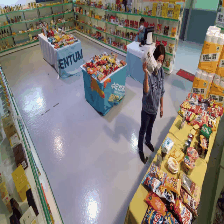

In [26]:
display_gif(sample_test_video['video'])

In [28]:
def run_inference(model, video):
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)
    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [31]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "./vivit-b-16x2-kinetics400-model/checkpoint-1800"
image_processor = VivitImageProcessor.from_pretrained(model_ckpt)
model = VivitForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

logits = run_inference(model, sample_test_video["video"])

In [32]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: put
